In [14]:
import pandas as pd
import numpy as np
import sqlite3

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error, r2_score

from scipy import stats
import statsmodels.api as sm

import torch
import torch.nn as nn
import torch.optim as optim

import time
import random

In [3]:
# make the lineplot of timeseries
def time_series_single(name, data, x, y, start, stop, size, color):
    print ('\033[1m'+name+'\033[m')
    print ('Начало периода: '+str(start)+', конец периода: '+str(stop))
    figure(figsize=size)
    sns.lineplot(data[x][data[x]>=start][data[x]<stop], data[y],color=color)
    plt.show()

In [70]:
# create features and targets dataframe
def create_Xy(data_ts, data_ex, exogenous_features,
              col_period,col_target,col_split,col_exgns_featrs, shifts):
    
    # create dataframe and main columns from time=series data
    Xy = pd.DataFrame()
    Xy['doc_date'] = data_ts[col_period]
    Xy['Split'] = data_ts[col_split]
    Xy['sum_of_sales'] = data_ts[col_target]

    # create features (targets in past)
    for shift in shifts:
        new_column = Xy['sum_of_sales'].shift(shift).to_numpy()
        Xy['sum_of_sales'+'_(t - '+str(shift)+')'] = new_column

    if exogenous_features == True:
        # append features from exogenous data
        Xy[col_exgns_featrs] = data_ex[col_exgns_featrs]

    # drop unnecessary rows
    #Xy = Xy[shift:]
    Xy = Xy[(Xy['Split']=='Train') | (Xy['Split']=='Test') | (Xy['Split']=='Forecast')]

    return Xy

In [71]:
def split_Xy(data, features):
    # create train samples
    X_train = pd.DataFrame()
    X_train[features] = Xy[features][Xy['Split']=='Train']
    y_train = pd.DataFrame()
    y_train['sum_of_sales'] = Xy['sum_of_sales'][Xy['Split']=='Train']

    # create test samples
    X_test = pd.DataFrame()
    X_test[features] = Xy[features][Xy['Split']=='Test']
    y_test = pd.DataFrame()
    y_test['sum_of_sales'] = Xy['sum_of_sales'][Xy['Split']=='Test']

    # create forecast samples
    X_forecast = pd.DataFrame()
    X_forecast[features] = Xy[features][Xy['Split']=='Forecast']
    
    return X_train, y_train, X_test, y_test, X_forecast

In [8]:
# build the forecast
def make_forecast_NN(length_frcst, exogenous_features, col_exgns_featrs, data, model):
    forecasts = []
    input_features = data[0:1].to_numpy()
    
    if exogenous_features == False:
        num_cols = data.shape[1]
        
        
        counter = 1
        for i in range(length_frcst):
            forecast = model(torch.tensor(input_features, dtype=torch.float)).cpu().detach().numpy()
            forecasts.append(forecast)
            counter +=1
            add_to_input = data[i+1:i+2].to_numpy()
            add_to_input = add_to_input[~np.isnan(add_to_input)].reshape(1,-1)
            input_features = np.hstack((np.array(forecasts)[::-1][:num_cols].reshape(1,-1), add_to_input))
    
    if exogenous_features == True:
        num_cols = data.shape[1] - len(col_exgns_featrs)
        
        ts_data = pd.DataFrame()
        ts_data[data.columns[:num_cols]] = data[data.columns[:num_cols]]
        
        ex_data = pd.DataFrame()
        ex_data[data.columns[num_cols:]] = data[data.columns[num_cols:]]
        
        counter = 1
        for i in range(length_frcst):
            forecast = model(torch.tensor(input_features, dtype=torch.float)).cpu().detach().numpy()
            forecasts.append(forecast)
            counter +=1
            ts_add_to_input = ts_data[i+1:i+2].to_numpy()
            ts_add_to_input = ts_add_to_input[~np.isnan(ts_add_to_input)].reshape(1,-1)
            input_features = np.hstack((np.array(forecasts)[::-1][:num_cols].reshape(1,-1), ts_add_to_input))
            input_features = np.hstack((input_features, ex_data[i+1:i+2].to_numpy().reshape(1,-1)))
        
        
        
        


    return np.array(forecasts).reshape(-1,1)

In [9]:
# create model quality report
def make_report_NN(name_report,
                true_train, true_test, predict_train, predict_test, forecast, 
                train_period, test_period, forecast_period, 
                model, features, graph_train, graph_test, graph_forecast, graph_coef,
                size_graph_1_1, size_graph_1_2, size_graph_2_1, size_graph_2_2, size_graph_3, size_graph_4):
    print ()
    print ('\033[4m' +'\033[1m' + 'REPORT - %s' %name_report + '\033[m')
    print ()
    print ('\033[1m' + 'Model' + '\033[m', model)
    print ('\033[1m' + 'Features' + '\033[m', features)
    print ()

    if graph_train is True:
#         print ('\033[4m' + 'TRAIN PERIOD: %s - %s' %(train_period[0],train_period[-1]) + '\033[m')
        print ('\033[4m' + '\033[1m' + 'TRAIN PERIOD:' +'\033[m' + '\033[4m', train_period[0],train_period[-1], '\033[m')
        print ()
        size = size_graph_1_1
        figure(figsize=size)
        plt.plot(train_period, true_train, color = 'green', label='True train')
        plt.plot(train_period, predict_train, color = 'red', label='Predict train')
        plt.xlabel("Period")
        plt.ylabel("Value")
        plt.legend()
        plt.show()
        print ('Average value: %u, RMSE: %u, %f%% (RMSE/AVG)' %(
            np.round(np.mean(true_train),2),
            np.round(mean_squared_error(true_train, predict_train)**0.5,2),
            100*np.round(mean_squared_error(true_train, predict_train)**0.5,2) / np.round(np.mean(true_train),2)
        ))
        print ('Coefficient of determination:', np.round(r2_score(true_train, predict_train),4))

        errors = true_train - predict_train
        size = (size_graph_1_2)
        figure(figsize=size)
        plt.plot(train_period, errors, color = 'red', label='Errors (true - predict)')
        plt.xlabel("Period")
        plt.ylabel("Value")
        plt.legend()
        plt.show()

        print ('Остатки модели смещены на ' + str(np.round(errors.to_numpy().mean(),2)))
        print ('Смещение составляет ' + str(np.round(errors.to_numpy().mean()*100/predict_train.mean(),2)) + 
               '%' + ' от среднего значения прогнозируемой величины в', np.round(predict_train.mean(),2))
        print('Критерий Дики-Фуллера: ' + 'p=' +
              str(np.round(sm.tsa.stattools.adfuller(errors.to_numpy())[1],150)))
        print ()

    if graph_test is True:
        print ('\033[4m' + '\033[1m' + 'TEST PERIOD:' +'\033[m' + '\033[4m', test_period[0],test_period[-1], '\033[m')
        print ()
        size = size_graph_2_1
        figure(figsize=size)
        plt.plot(test_period, true_test, color = 'green', label='True test')
        plt.plot(test_period, predict_test, color = 'red', label='Predict test')
        plt.xlabel("Period")
        plt.ylabel("Value")
        plt.legend()
        plt.show()
        print ('Average value: %u, RMSE: %u, %f%% (RMSE/AVG)' %(
            np.round(np.mean(true_test),2),
            np.round(mean_squared_error(true_test, predict_test)**0.5,2),
            100*np.round(mean_squared_error(true_test, predict_test)**0.5,2) / np.round(np.mean(true_test),2)
        ))
        print ('Coefficient of determination:', np.round(r2_score(true_test, predict_test),4))

        errors = true_test - predict_test
        size = size_graph_2_2
        figure(figsize=size)
        plt.plot(test_period, errors, color = 'red', label='Errors (true - predict)')
        plt.xlabel("Period")
        plt.ylabel("Value")
        plt.legend()
        plt.show()

        print ('Остатки модели смещены на ' + str(np.round(errors.to_numpy().mean(),2)))
        print ('Смещение составляет ' + str(np.round(errors.to_numpy().mean()*100/predict_test.mean(),2)) + 
               '%'  + ' от среднего значения прогнозируемой величины в', np.round(predict_test.mean(),2))
        print('Критерий Дики-Фуллера: ' + 'p=' +
              str(np.round(sm.tsa.stattools.adfuller(errors.to_numpy())[1],150)))
        print ()
        
    if graph_forecast is True:
        print ('\033[4m' + '\033[1m' + 'TRAIN + TEST + FORECAST:' +'\033[m' + '\033[4m', test_period[0],forecast_period[-1], '\033[m')
        print ()
        size = size_graph_3
        figure(figsize=size)
        plt.plot(train_period, true_train, color = 'green', label='True train')
        plt.plot(train_period, predict_train, color = 'red', label='Predict train')
        plt.plot(test_period, true_test, color = 'darkgreen', label='True test')
        plt.plot(test_period, predict_test, color = 'darkred', label='Predict test')
        plt.plot(forecast_period, forecast, color = 'darkred', label='Forecast', linestyle = 'dashed')
        plt.xlabel("Period")
        plt.ylabel("Value")
        plt.legend()
        plt.show()

    if graph_coef is True:
        print ('\033[1m' + '\033[4m' + 'Coefficients values' + '\033[m')
        df = pd.DataFrame()
        df['Feature'] = features
        df['Coef'] = [param for name, param in model.named_parameters()][0].cpu().detach().numpy().reshape(-1,1)
        df = df.sort_values(by=['Coef'])
        size = size_graph_4
        figure(figsize=size)
        plt.bar(df['Feature'], df['Coef'], color = 'grey')
        plt.xlabel("Features")
        plt.ylabel("Value of coefficient")
        plt.xticks(rotation=75)
        plt.show()
        
        
    if graph_test is True:
        MODEL = model
        RMSE = np.round(mean_squared_error(true_test, predict_test)**0.5,2)
        CoefDetrMntN = np.round(r2_score(true_test, predict_test),4)
        AVG = np.round(np.mean(true_test.to_numpy()),2)
        PERCENTS = 100*np.round(
            mean_squared_error(true_test.to_numpy(), predict_test)**0.5,2) / \
            np.round(np.mean(true_test.to_numpy()),2)
        
        return MODEL, RMSE, CoefDetrMntN, AVG, PERCENTS
    
    if graph_test is False:
        
        return _, _, _, _, _

In [10]:
def report_pivot_model_statistics(model_statistics, train_period, test_period, forecast_period):
    print ()
    print ('\033[4m' + '\033[1m' + 'PIVOT TABLE "Multyple model statistics" on TEST DATA' + '\033[m')
    print ()
    print ('\033[4m' + 'Periods:' + '\033[m')
    print ('  - train:    ', train_period[0], '-', train_period[-1])
    print ('  - test:     ', test_period[0], '-', test_period[-1])
    print ('  - forecast: ', forecast_period[0], '-', forecast_period[-1])
    display(model_statistics.round(4))

In [11]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [12]:
class Model_1(nn.Module):
    def __init__(self, input_size, output_size):
        super(Model_1, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.linear = nn.Linear(self.input_size, self.output_size)
        
    def forward(self, x):
        output = self.linear(x)
        return output

In [13]:
def random_init(SEED):
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    torch.backends.cudnn.enabled=False
    torch.backends.cudnn.deterministic=True

In [15]:
cnx = sqlite3.connect('../sales_db/data/sqlite.db')
# без сиропов
query = """SELECT * FROM v_sales
            WHERE ta_type = 'Кофейный ТА' AND ta_cell_number <= 90"""
sales = pd.read_sql_query(query, cnx)

In [16]:
sales.to_pickle('sales.pkl')

In [72]:
sales = pd.read_pickle('sales.pkl')

In [73]:
sales.sum_of_sales = sales.sum_of_sales.astype('float64')

In [74]:
sales.doc_date = pd.to_datetime(sales.doc_date, dayfirst=True)
sales = sales[sales['division'].str.contains('ЦЕХ') == False]

In [60]:
sales.isnull().sum()

doc_number                      0
doc_date                        0
ta_serial                       0
ta_type                         0
division                        0
tt_name                         0
ta_cell_number                  0
product                       463
number_of_sales                 0
sum_of_sales                    0
product_cost_price              0
product_control_cost_price      0
dtype: int64

In [75]:
sales = sales[['doc_date','sum_of_sales']]

In [76]:
sales = sales.groupby('doc_date').sum().reset_index()

In [77]:
#sales_series = sales_grouped.set_index('doc_date')

In [78]:
sales

,doc_date,sum_of_sales
0,2021-01-01,238338.0
1,2021-01-02,241299.0
2,2021-01-03,253415.0
3,2021-01-04,280594.0
4,2021-01-05,284135.0
...,...,...
1090,2023-12-27,869982.0
1091,2023-12-28,881639.0
1092,2023-12-29,715564.0
1093,2023-12-30,453212.0


In [79]:
# select PERIOD for TRAIN, TEST, FORECAST
trn_start, trn_stop = '2021-01-01', '2023-12-17'
trn_period = pd.date_range(trn_start, trn_stop, freq="D")
tst_start, tst_stop = '2023-12-18', '2023-12-31'
tst_period = pd.date_range(tst_start, tst_stop, freq="D")
frcst_start, frcst_stop = '2024-01-01', '2024-02-25'
frcst_period = pd.date_range(frcst_start, frcst_stop, freq="d")

# create column with label of split sample for train & test 
sales['Split'] = sales['doc_date']
sales.loc[
    (sales['doc_date'] >= trn_start) & (sales['doc_date'] <= trn_stop), 'Split'] = 'Train'
sales.loc[
    (sales['doc_date'] >= tst_start) & (sales['doc_date'] <= tst_stop), 'Split'] = 'Test'

# create column with label of split sample for forecast
data = pd.DataFrame()
data['doc_date'] = pd.date_range(frcst_start, frcst_stop, freq="D")
data['sum_of_sales'] = None
data['Split'] = 'Forecast'
sales = pd.concat([sales, data], ignore_index = True)

sales.tail(3)

,doc_date,sum_of_sales,Split
1148,2024-02-23,NaN,Forecast
1149,2024-02-24,NaN,Forecast
1150,2024-02-25,NaN,Forecast


In [80]:
# create exogenous time-series data
exogen_TS_data = pd.DataFrame()
exogen_TS_data['doc_date'] = sales['doc_date']
# create column for number of month
exogen_TS_data['Month'] = exogen_TS_data['doc_date'].dt.month
# create NEW FEATURE column for number of days per month
exogen_TS_data['Days_in_month'] = exogen_TS_data['doc_date'].dt.daysinmonth
# create NEW FEATURES columns-labels for number of month
mounths = [1,2,3,4,5,6,7,8,9,10,11,12]
for mounth in mounths:
    exogen_TS_data['month_'+str(mounth)] = 0
    exogen_TS_data['month_'+str(mounth)][exogen_TS_data['Month']==mounth]=1

display(exogen_TS_data.head(3))
display(exogen_TS_data.info())

,doc_date,Month,Days_in_month,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2021-01-01,1,31,1,0,0,0,0,0,0,0,0,0,0,0
1,2021-01-02,1,31,1,0,0,0,0,0,0,0,0,0,0,0
2,2021-01-03,1,31,1,0,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   doc_date       1151 non-null   datetime64[ns]
 1   Month          1151 non-null   int32         
 2   Days_in_month  1151 non-null   int32         
 3   month_1        1151 non-null   int64         
 4   month_2        1151 non-null   int64         
 5   month_3        1151 non-null   int64         
 6   month_4        1151 non-null   int64         
 7   month_5        1151 non-null   int64         
 8   month_6        1151 non-null   int64         
 9   month_7        1151 non-null   int64         
 10  month_8        1151 non-null   int64         
 11  month_9        1151 non-null   int64         
 12  month_10       1151 non-null   int64         
 13  month_11       1151 non-null   int64         
 14  month_12       1151 non-null   int64         
dtypes: datetime64[ns](1),

None

#### Create dataset - 24 past raw time-series only

In [81]:
# create Xy

# select params
data_ts, data_ex = sales, exogen_TS_data
exogenous_features = False
col_period, col_target, col_split = 'doc_date', 'sum_of_sales', 'Split'
col_exgns_featrs = exogen_TS_data.columns[2:]
shifts = np.arange(1, 13, 1) # select period in past to predict target value

# use function to create Xy
Xy = create_Xy(data_ts, data_ex, exogenous_features,
              col_period,col_target,col_split,col_exgns_featrs, shifts)

Xy.head(2)

,doc_date,Split,sum_of_sales,sum_of_sales_(t - 1),sum_of_sales_(t - 2),sum_of_sales_(t - 3),sum_of_sales_(t - 4),sum_of_sales_(t - 5),sum_of_sales_(t - 6),sum_of_sales_(t - 7),sum_of_sales_(t - 8),sum_of_sales_(t - 9),sum_of_sales_(t - 10),sum_of_sales_(t - 11),sum_of_sales_(t - 12)
12,2021-01-13,Train,429416.0,407479.0,387937.0,266546.0,297536.0,273541.0,251220.0,283729.0,284135.0,280594.0,253415.0,241299.0,238338.0
13,2021-01-14,Train,418657.0,429416.0,407479.0,387937.0,266546.0,297536.0,273541.0,251220.0,283729.0,284135.0,280594.0,253415.0,241299.0


In [82]:
# split Xy to train, test & forecast
# select params
data = Xy
features = Xy.columns[3:]
# split
X_train, y_train, X_test, y_test, X_forecast = split_Xy(data, features)

Epoch: 1
Learning rate: 0.05
Last loss on TRAIN data: 6279054300.0               Last loss on TEST data: 3368720000.0


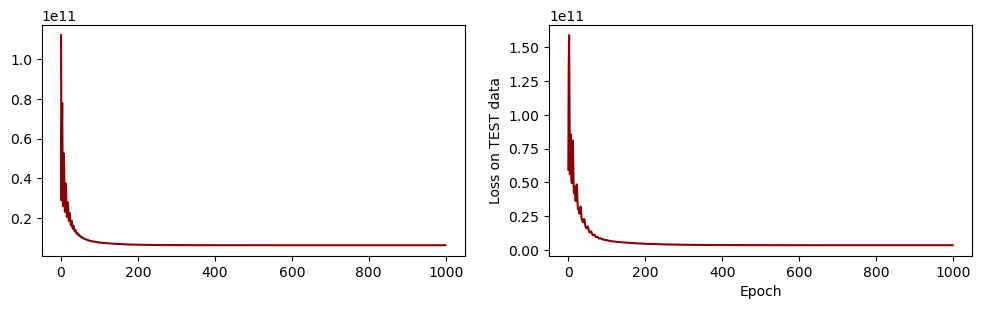

Epoch: 2
Learning rate: 0.007
Last loss on TRAIN data: 6279040000.0               Last loss on TEST data: 3368552000.0


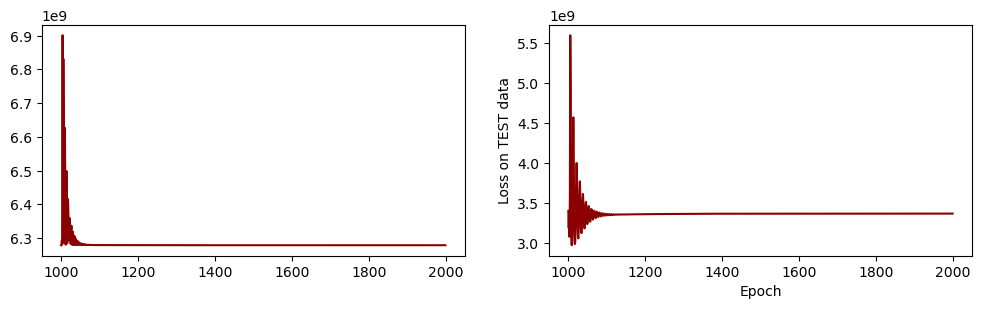

Epoch: 3
Learning rate: 0.007
Last loss on TRAIN data: 6279020000.0               Last loss on TEST data: 3368484900.0


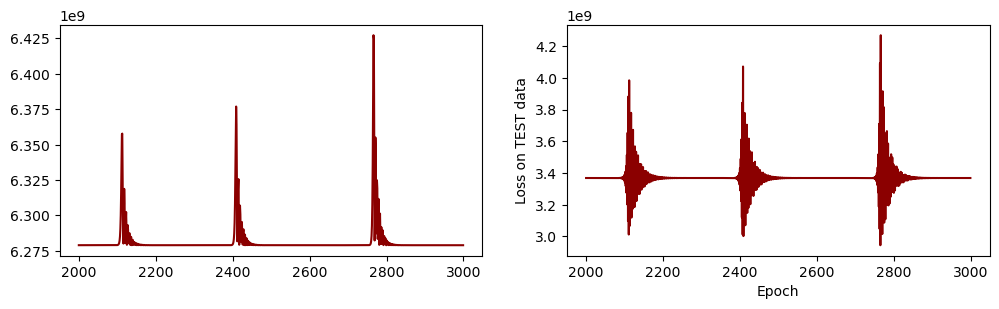

Epoch: 4
Learning rate: 0.007
Last loss on TRAIN data: 6279042000.0               Last loss on TEST data: 3355841300.0


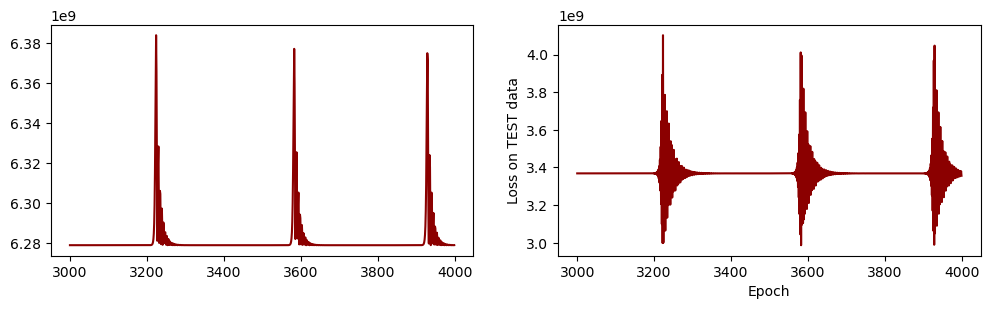

Epoch: 5
Learning rate: 0.007
Last loss on TRAIN data: 6279126500.0               Last loss on TEST data: 3357945600.0


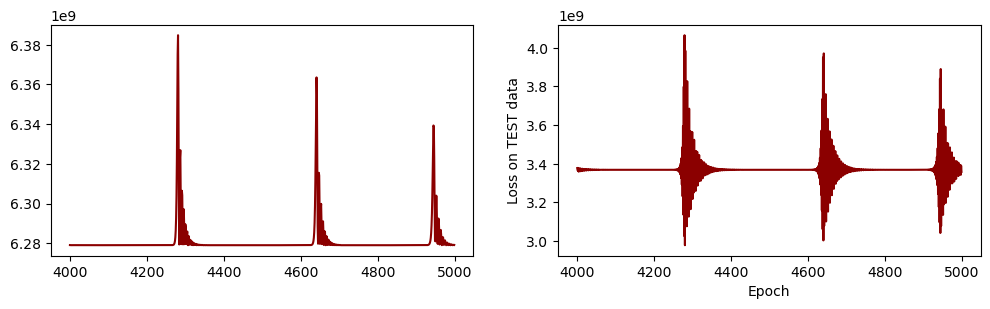

Epoch: 6
Learning rate: 0.007
Last loss on TRAIN data: 6278958600.0               Last loss on TEST data: 3368342000.0


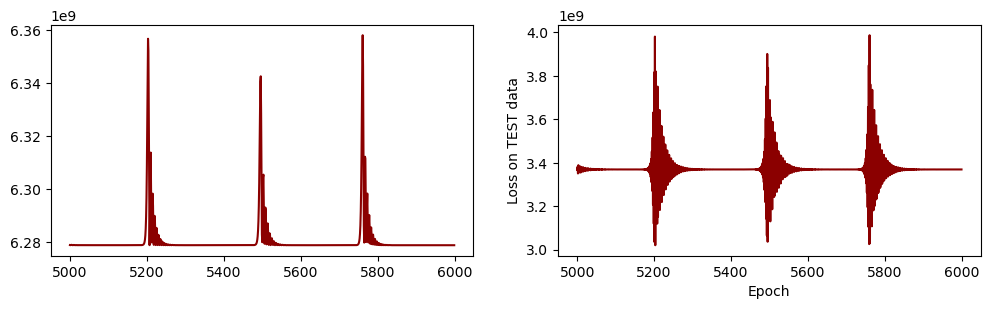

Epoch: 7
Learning rate: 0.007
Last loss on TRAIN data: 6278937600.0               Last loss on TEST data: 3368258300.0


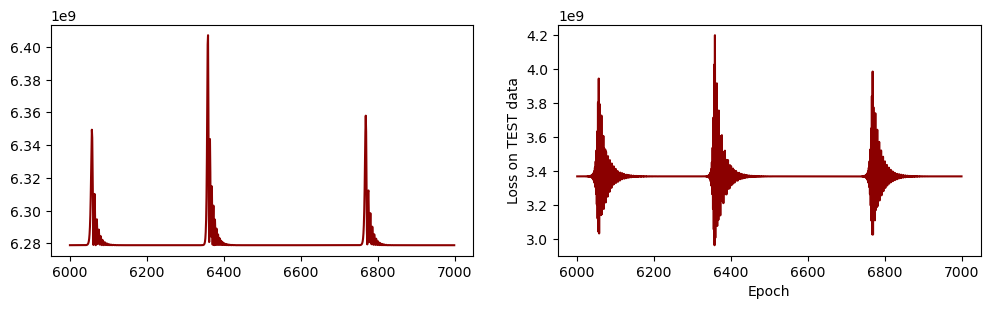

Epoch: 8
Learning rate: 0.007
Last loss on TRAIN data: 6310760000.0               Last loss on TEST data: 3597813800.0


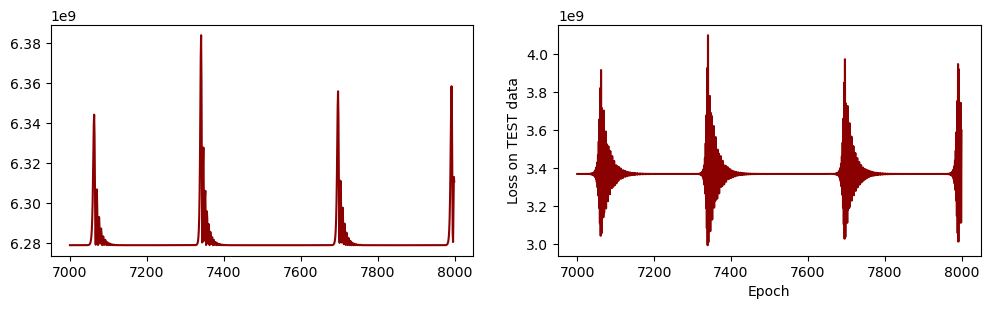

Epoch: 9
Learning rate: 0.007
Last loss on TRAIN data: 6278897000.0               Last loss on TEST data: 3368142600.0


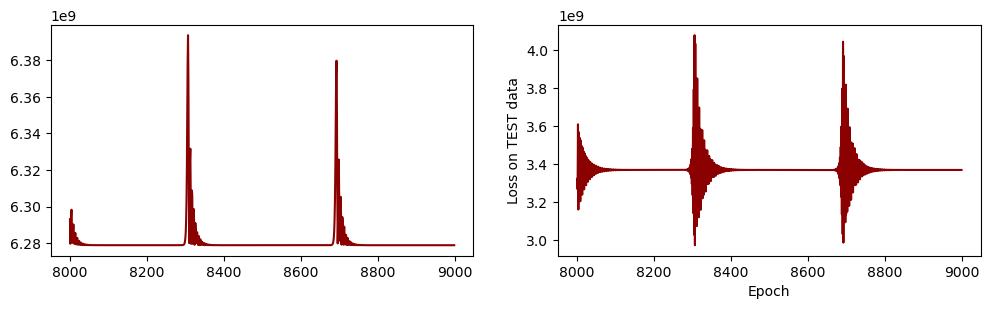

Epoch: 10
Learning rate: 0.007
Last loss on TRAIN data: 6278876000.0               Last loss on TEST data: 3368131800.0


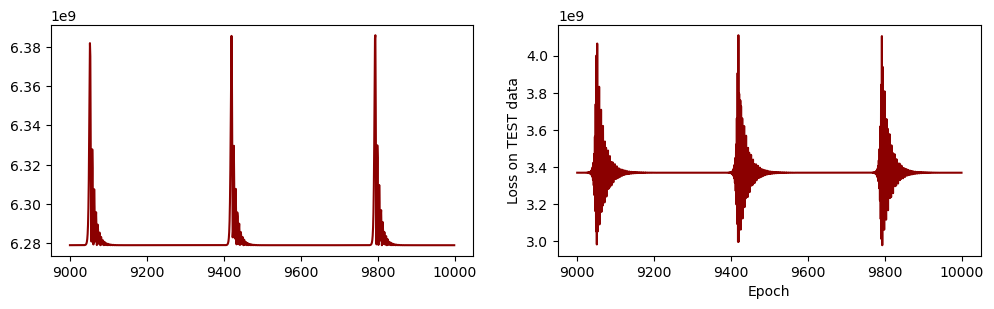

Epoch: 11
Learning rate: 0.007
Last loss on TRAIN data: 6278855700.0               Last loss on TEST data: 3368069000.0


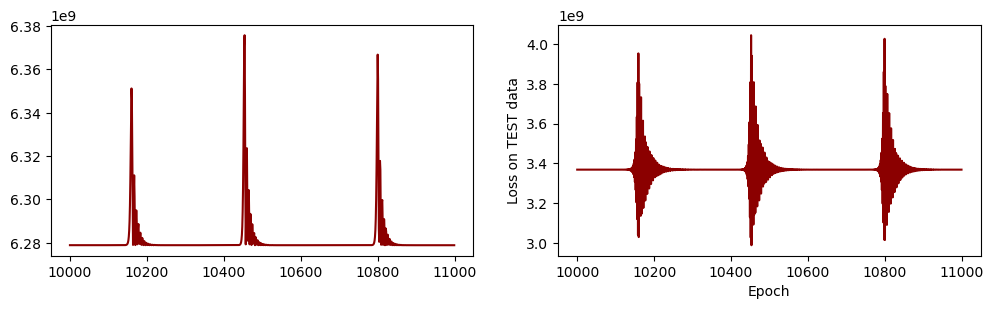

Epoch: 12
Learning rate: 0.007
Last loss on TRAIN data: 6278835000.0               Last loss on TEST data: 3368014000.0


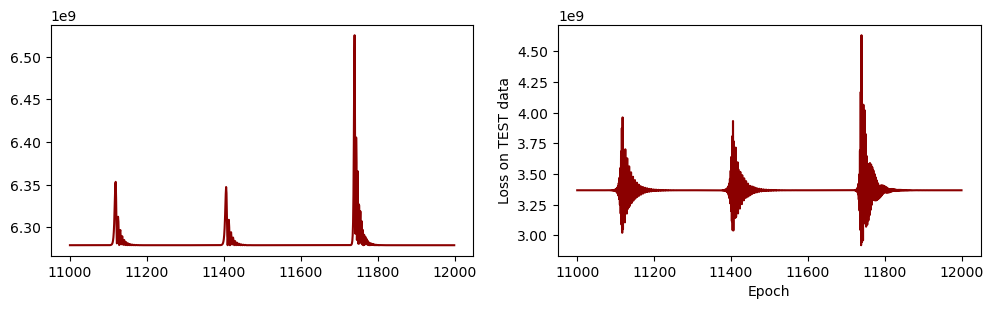

Epoch: 13
Learning rate: 0.007
Last loss on TRAIN data: 6280843300.0               Last loss on TEST data: 3269084000.0


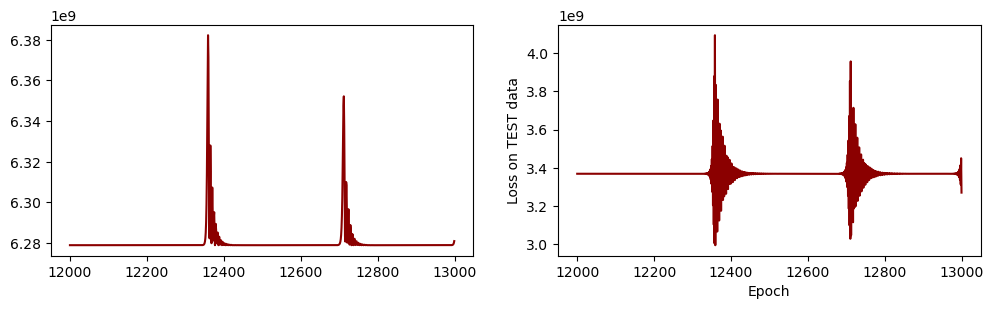

Epoch: 14
Learning rate: 0.007
Last loss on TRAIN data: 6278814000.0               Last loss on TEST data: 3362827000.0


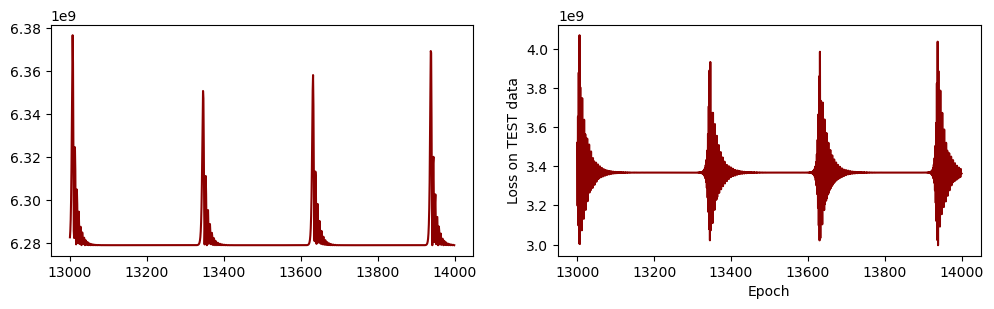

In [83]:
# fix the random seed
SEED = 42
random_init(SEED)

# initialization model, loss function, optimizator
model = Model_1(len(features),1)
loss_func = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=5e-2)

# set the epoch numbers, initialization list for every loss after learning on epoch
epochs = 15000
losses_train = []
losses_test = []
# initialization counter for calculation epoch numbers
counter = 0
# start the learning model
for epoch in range(epochs):
    model.train()
#     make prediction targets on train data
    y_pred_train = model(torch.tensor(X_train.to_numpy(), dtype=torch.float))
#     calculate loss
    loss = loss_func(y_pred_train, 
                     torch.reshape(torch.tensor(y_train.to_numpy(), dtype=torch.float),(-1,1)))
#     bacward loss to model and calculate new parameters (coefficients) with fixed learning rate
    loss.backward()
    opt.step()
    opt.zero_grad()

# add loss to list losses 
    losses_train.append(loss)
    
    model.eval()
    y_pred_test = model(torch.tensor(X_test.to_numpy(), dtype=torch.float))
    loss_test = loss_func(y_pred_test, 
                     torch.reshape(torch.tensor(y_test.to_numpy(), dtype=torch.float),(-1,1)))
    losses_test.append(loss_test)
    
    
# make the mini report for every 1000 epoch    
    if epoch % 1000 == 0 and epoch > 0:
        print ('Epoch:', epoch // 1000)
        print ('Learning rate:', opt.param_groups[0]['lr'])
        print ('Last loss on TRAIN data:', losses_train[-1].cpu().detach().numpy(),
              '              Last loss on TEST data:', losses_test[-1].cpu().detach().numpy())
#         print ('Last loss on TEST data:', losses_test[-1].cpu().detach().numpy())
        fig, (ax1, ax2) = plt.subplots(1, 2)
#         fig.suptitle('MSE on TRAIN & TEST DATA')
        fig.set_figheight(3)
        fig.set_figwidth(12)
        ax1.plot(np.arange(counter,epoch,1), np.array([float(i) for i in losses_train][-1000:]), color = 'darkred')
        plt.xlabel("Epoch")
        plt.ylabel("Loss on TRAIN data")
        ax2.plot(np.arange(counter,epoch,1), np.array([float(i) for i in losses_test][-1000:]), color = 'darkred')
        plt.xlabel("Epoch")
        plt.ylabel("Loss on TEST data")
        plt.show()
        
        counter += 1000
        
#   reduce learning rate
    if epoch == 1000:
        opt = torch.optim.Adam(model.parameters(), lr=7e-3)
        


REPORT - ORIGINAL VALUES

Model Model_1(
  (linear): Linear(in_features=12, out_features=1, bias=True)
)
Features ['sum_of_sales_(t - 1)', 'sum_of_sales_(t - 2)', 'sum_of_sales_(t - 3)', 'sum_of_sales_(t - 4)', 'sum_of_sales_(t - 5)', 'sum_of_sales_(t - 6)', 'sum_of_sales_(t - 7)', 'sum_of_sales_(t - 8)', 'sum_of_sales_(t - 9)', 'sum_of_sales_(t - 10)', 'sum_of_sales_(t - 11)', 'sum_of_sales_(t - 12)']

TRAIN PERIOD: 2021-01-01 00:00:00 2023-12-17 00:00:00 



ValueError: x and y must have same first dimension, but have shapes (1081,) and (1069, 1)

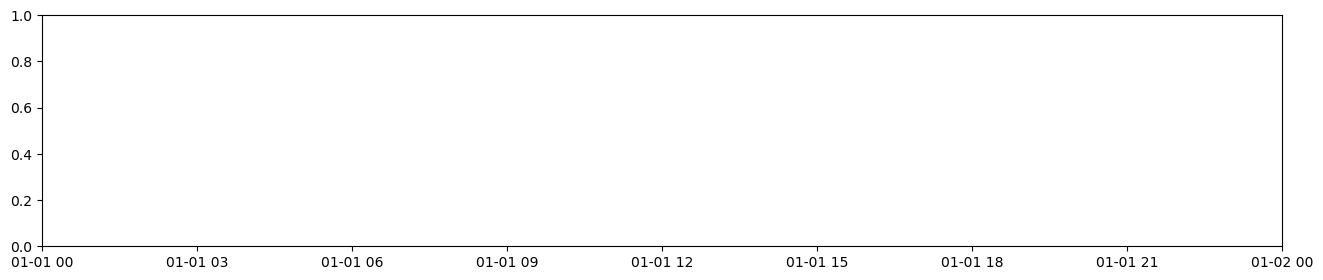

In [84]:
# create predict for train & test
predict_train = model(torch.tensor(X_train.to_numpy(), dtype=torch.float)).cpu().detach().numpy()
predict_test = model(torch.tensor(X_test.to_numpy(), dtype=torch.float)).cpu().detach().numpy()

# create forecasts
# select params
length_frcst = frcst_period.shape[0]
exogenous_features = exogenous_features
col_exgns_featrs = col_exgns_featrs
data = Xy[Xy['Split']=='Forecast'][Xy.columns[3:]]
model = model
# build the forecast
forecasts = make_forecast_NN(length_frcst, exogenous_features, col_exgns_featrs, data, model)

# check the quality of the model on the training and test set, build a forecast

# select the params
name_report = 'ORIGINAL VALUES'
true_train, true_test = y_train, y_test
predict_train, predict_test, forecast = predict_train, predict_test, forecasts
train_period, test_period, forecast_period = trn_period, tst_period, frcst_period
model = model
features = Xy.columns[3:].to_list()
graph_train = True
graph_test = True
graph_forecast = True
graph_coef = True
size_graph_1_1, size_graph_1_2, size_graph_2_1, size_graph_2_2, size_graph_3, size_graph_4 = \
    (16,3), (16,1), (7,1.5), (7,1), (16,3), (16,1)

MODEL, RMSE, CoefDetrmntn, AVG, PERCENTS = make_report_NN(name_report, 
                true_train, true_test, predict_train, predict_test, forecast, 
                train_period, test_period, forecast_period, 
                model, features, graph_train, graph_test, graph_forecast, graph_coef,
                size_graph_1_1, size_graph_1_2, size_graph_2_1, size_graph_2_2, size_graph_3, size_graph_4)